In [1]:
import pandas as pd
from pandas import DataFrame, Series

import sqlite3
import os

import matplotlib
from matplotlib import pyplot as plt

import requests
matplotlib.rcParams["font.size"] = 12

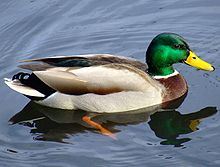

### IRIS dataset: http://archive.ics.uci.edu/ml/datasets/iris
- This set of data is used in beginning Machine Learning Courses
- You can train a ML algorithm to use the values to predict the class of iris
- Dataset link: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

In [2]:
# Warmup 1:  Requests and file writing

# use requests to get this file  "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
response = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

# check that the request was successful
response.raise_for_status()

# open a file called "iris.csv" for writing the data locally to avoid spamming their server
file_obj = open("iris.csv", "w")

# write the text of response to the file object
file_obj.write(response.text)

# close the file object
file_obj.close()

# Look at the file you downloaded. What's wrong with it?

In [3]:
# Warmup 2:  Making a DataFrame

# read the "iris.csv" file into a Pandas dataframe
iris_df = pd.read_csv("iris.csv")

# display the head of the data frame
iris_df.head()

,5.1,3.5,1.4,0.2,Iris-setosa
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [4]:
# Warmup 3: Our CSV file has no header....let's add column names.
#           Refer to the documentation: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# Attribute Information:
# 1. sepal length in cm
# 2. sepal width in cm
# 3. petal length in cm
# 4. petal width in cm
# 5. class: Iris Setosa, Iris Versicolour, Iris Virginica

# These should be our headers ["sep-length", "sep-width", "pet-length", "pet-width", "class"]


iris_df = pd.read_csv("iris.csv",
                 names=["sep-length", "sep-width", "pet-length", "pet-width", "class"])
iris_df.head()

,sep-length,sep-width,pet-length,pet-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
# Warmup 4: Connect to our database version of this data!
iris_conn = sqlite3.connect("iris-flowers.db")
pd.read_sql("SELECT * FROM sqlite_master WHERE type='table'", iris_conn)

,type,name,tbl_name,rootpage,sql
0,table,iris,iris,2,"CREATE TABLE ""iris"" (\n""sep-length"" REAL,\n ""..."


In [6]:
# Warmup 5: Using SQL, get the 10 'Iris-setosa' flowers with the longest sepal length.
#           Break any ties by ordering by the shortest sepal width.

pd.read_sql("""
    SELECT *
    FROM iris
    WHERE class = 'Iris-setosa'
    ORDER BY `sep-length` DESC, `sep-width` ASC
    LIMIT 10
""", iris_conn)

,sep-length,sep-width,pet-length,pet-width,class
0,5.8,4.0,1.2,0.2,Iris-setosa
1,5.7,3.8,1.7,0.3,Iris-setosa
2,5.7,4.4,1.5,0.4,Iris-setosa
3,5.5,3.5,1.3,0.2,Iris-setosa
4,5.5,4.2,1.4,0.2,Iris-setosa
5,5.4,3.4,1.7,0.2,Iris-setosa
6,5.4,3.4,1.5,0.4,Iris-setosa
7,5.4,3.7,1.5,0.2,Iris-setosa
8,5.4,3.9,1.7,0.4,Iris-setosa
9,5.4,3.9,1.3,0.4,Iris-setosa


In [7]:
# Warmup 6: Using SQL, get the average petal length and width for each class of flower.

pd.read_sql("""
SELECT class, AVG("pet-length"), AVG("pet-width")
FROM iris
GROUP BY class
""", iris_conn)

,class,"AVG(""pet-length"")","AVG(""pet-width"")"
0,Iris-setosa,1.464,0.244
1,Iris-versicolor,4.260,1.326
2,Iris-virginica,5.552,2.026


# Lecture 35:  Scatter Plots
**Learning Objectives**
- Set the marker, color, and size of scatter plot data
- Calculate correlation between DataFrame columns
- Use subplots to group scatterplot data

## Set the marker, color, and size of scatter plot data

To start, let's look at some made-up data about Trees.
The city of Madison maintains a database of all the trees they care for.

In [8]:
trees = [
    {"age": 1, "height": 1.5, "diameter": 0.8},
    {"age": 1, "height": 1.9, "diameter": 1.2},
    {"age": 1, "height": 1.8, "diameter": 1.4},
    {"age": 2, "height": 1.8, "diameter": 0.9},
    {"age": 2, "height": 2.5, "diameter": 1.5},
    {"age": 2, "height": 3, "diameter": 1.8},
    {"age": 2, "height": 2.9, "diameter": 1.7},
    {"age": 3, "height": 3.2, "diameter": 2.1},
    {"age": 3, "height": 3, "diameter": 2},
    {"age": 3, "height": 2.4, "diameter": 2.2},
    {"age": 2, "height": 3.1, "diameter": 2.9},
    {"age": 4, "height": 2.5, "diameter": 3.1},
    {"age": 4, "height": 3.9, "diameter": 3.1},
    {"age": 4, "height": 4.9, "diameter": 2.8},
    {"age": 4, "height": 5.2, "diameter": 3.5},
    {"age": 4, "height": 4.8, "diameter": 4},
]
trees_df = DataFrame(trees)
trees_df.head()

,age,height,diameter
0,1,1.5,0.8
1,1,1.9,1.2
2,1,1.8,1.4
3,2,1.8,0.9
4,2,2.5,1.5


### Scatter Plots
We can make a scatter plot of a DataFrame using the following function...

`df_name.plot.scatter(x="x_col_name", y="y_col_name", color="peachpuff")`

Plot the trees data comparing a tree's age to its height...
 - What is `df_name`?
 - What is `x_col_name`?
 - What is `y_col_name`?

<Axes: xlabel='age', ylabel='height'>

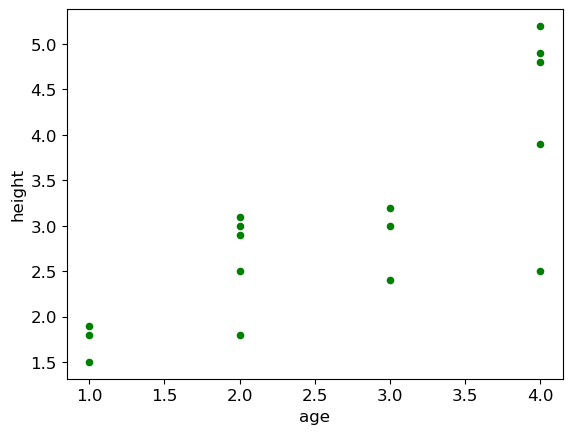

In [9]:
trees_df.plot.scatter(x="age", y="height", color = "g")  # TODO: change y to diameter

Now plot with a little more beautification...
 - Use a new [color](https://matplotlib.org/3.5.0/_images/sphx_glr_named_colors_003.png)
 - Use a type of [marker](https://matplotlib.org/stable/api/markers_api.html)
 - Change the size (any int)

<Axes: xlabel='age', ylabel='height'>

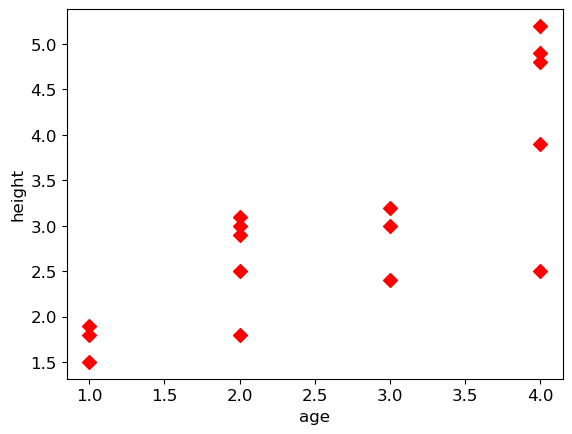

In [10]:
# Plot with some more beautification options.
trees_df.plot.scatter(x="age", y="height", color="r",  marker = "D", s=50) # D for diamond

Text(0.5, 1.0, 'Tree Age vs Height')

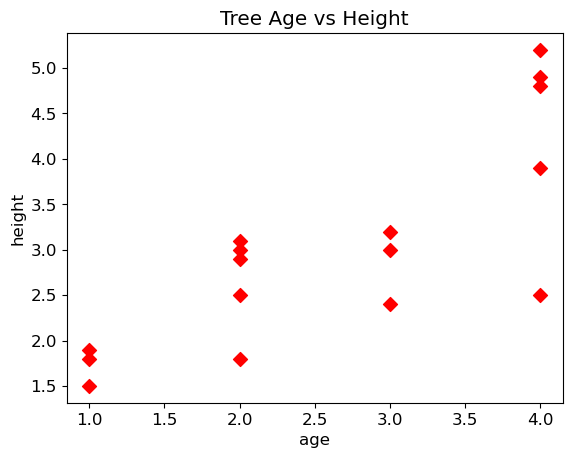

In [11]:
# Add a title to your plot.
ax = trees_df.plot.scatter(x="age", y="height", color="r", marker = "D", s=50) # D for diamond
ax.set_title("Tree Age vs Height")

#### Correlation

In [12]:
# What is the correlation between our DataFrame columns?
corr_df = trees_df.corr()
corr_df

,age,height,diameter
age,1.000000,0.797468,0.854578
height,0.797468,1.000000,0.839345
diameter,0.854578,0.839345,1.000000


In [13]:
# What is the correlation between age and height (don't use .iloc)
corr_df['age']['height']

0.7974683544303798

### Variating Stylistic Parameters

<Axes: xlabel='age', ylabel='height'>

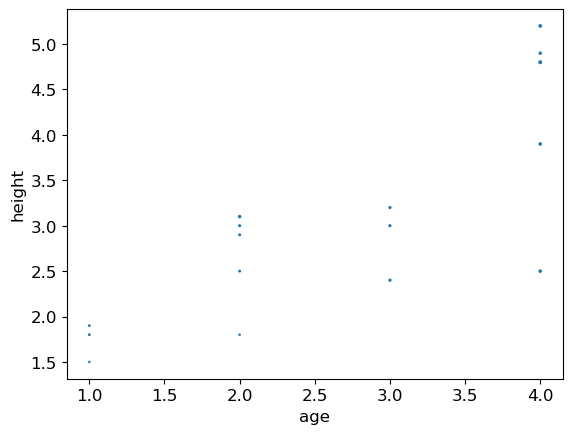

In [14]:
# Option 1:
trees_df.plot.scatter(x="age", y="height",  marker="H", s="diameter")

<Axes: xlabel='age', ylabel='height'>

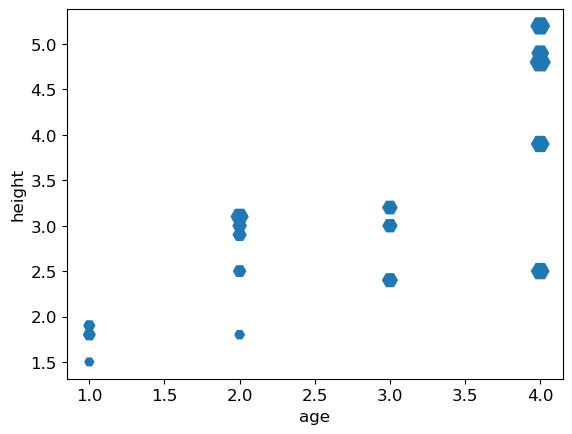

In [15]:
# Option 2:
trees_df.plot.scatter(x="age", y="height", marker = "H", s=trees_df["diameter"] * 50) # this way allows you to make it bigger

## Use subplots to group scatterplot data

### Re-visit the Iris Data


In [16]:
iris_df

,sep-length,sep-width,pet-length,pet-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### How do we create a *scatter plot* for various *class types*?
First, gather all the class types.

In [17]:
# In Pandas
varietes = list(set(iris_df["class"]))
varietes

['Iris-virginica', 'Iris-setosa', 'Iris-versicolor']

In [18]:
# In SQL
varietes = list(pd.read_sql("""
    SELECT DISTINCT class
    FROM iris
""", iris_conn)["class"])
varietes

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In reality, you can choose to write Pandas or SQL queries (or a mix of both!). For the rest of this lecture, we'll use Pandas.

In [19]:
# If you want to continue using SQL instead, don't close the connection!
iris_conn.close()

<Axes: xlabel='pet-width', ylabel='pet-length'>

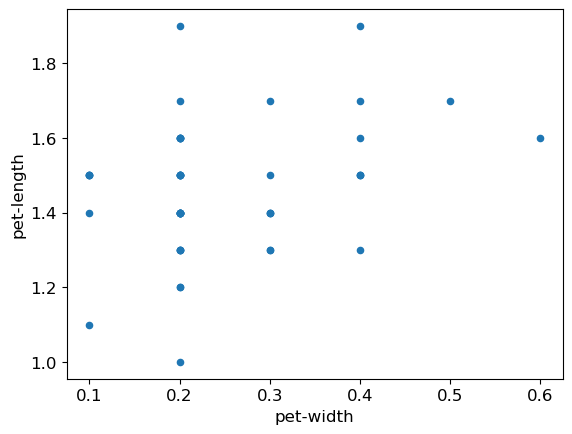

In [20]:
# Change this scatter plot so that the data is only for class ='Iris-setosa'
iris_df[iris_df["class"] == 'Iris-setosa'].plot.scatter(x = "pet-width", y = "pet-length")

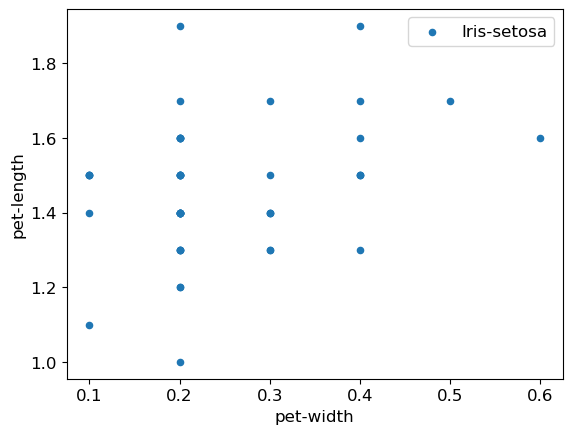

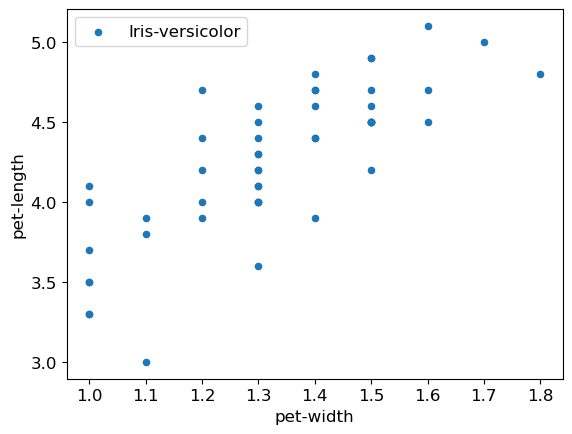

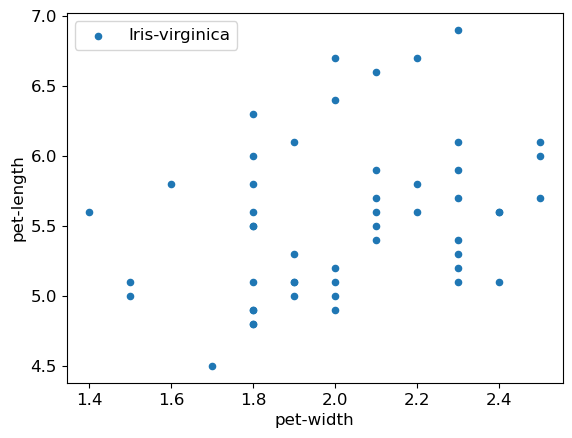

In [21]:
# Write a for loop that iterates through each variety in classes
# and makes a plot for only that class

for i in range(len(varietes)):
    variety = varietes[i]
    
    # make a df just of just the data for this variety
    variety_df = iris_df[iris_df["class"] == variety] 
    
    #make a scatter plot for this variety
    variety_df.plot.scatter(x = "pet-width", y = "pet-length", label=variety)

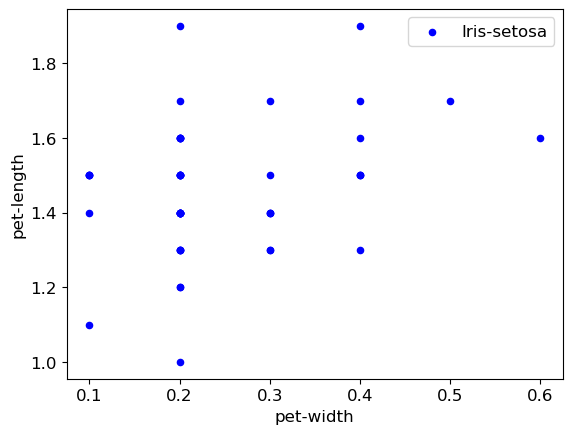

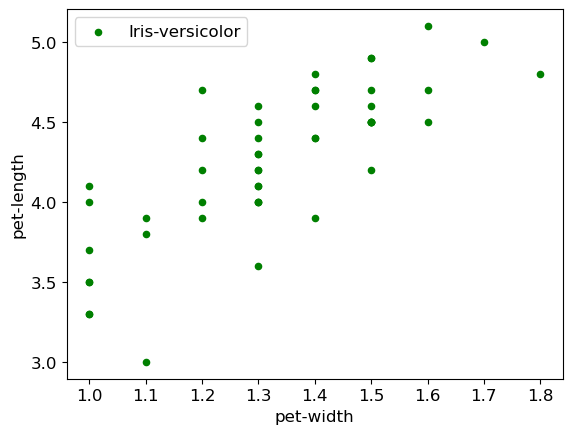

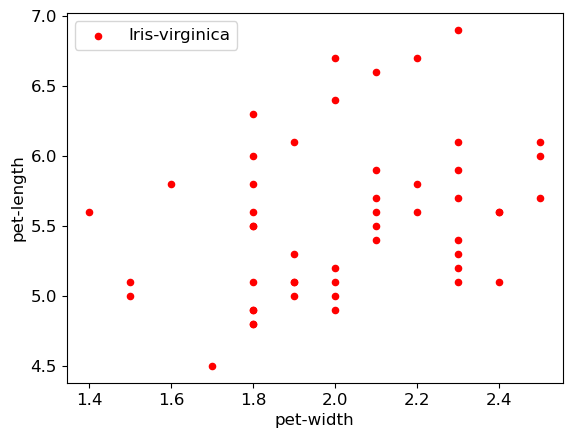

In [22]:
# copy/paste the code above, but this time make each plot a different color
colors = ["blue", "green", "red"]
for i in range(len(varietes)):
    variety = varietes[i]
    
    # make a df just of just the data for this variety
    variety_df = iris_df[iris_df["class"] == variety] 
    
    #make a scatter plot for this variety
    variety_df.plot.scatter(x = "pet-width", y = "pet-length", label=variety, color=colors[i])


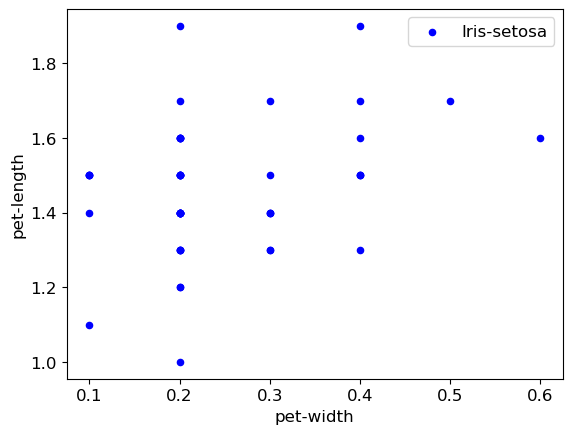

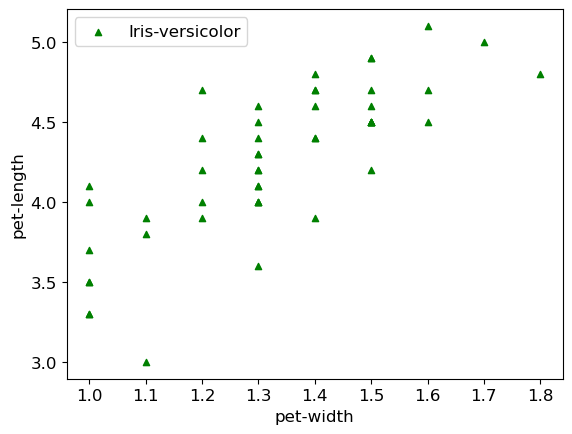

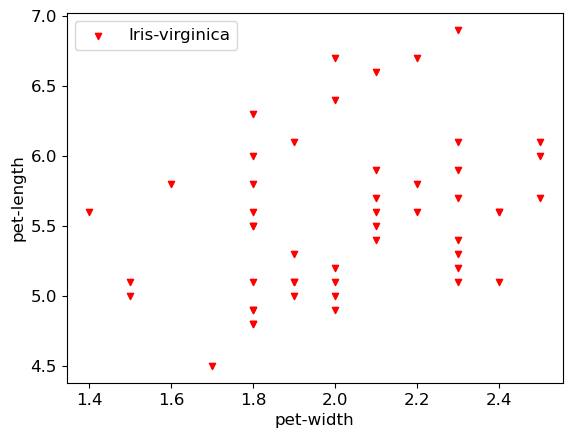

In [23]:
# copy/paste the code above, but this time make each plot a different color AND marker
colors = ["blue", "green", "red"]
markers = ["o", "^", "v"]
for i in range(len(varietes)):
    variety = varietes[i]
    
    # make a df just of just the data for this variety
    variety_df = iris_df[iris_df["class"] == variety] 
    
    #make a scatter plot for this variety
    variety_df.plot.scatter(x = "pet-width", y = "pet-length", label=variety, color=colors[i], marker=markers[i])

In [24]:
# Did you notice that it made 3 plots?!?! What's decieving about this?

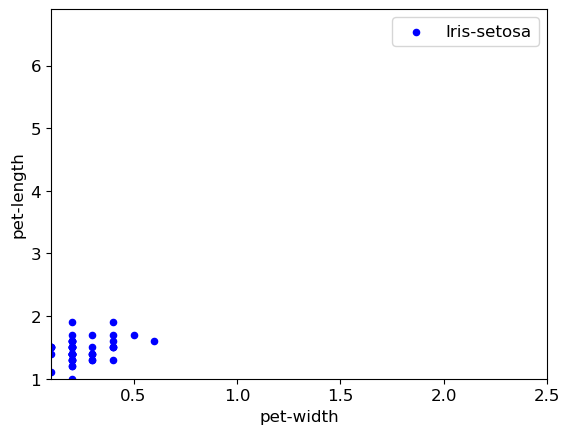

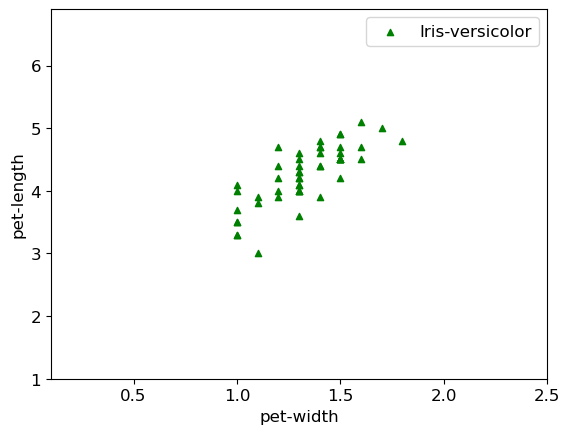

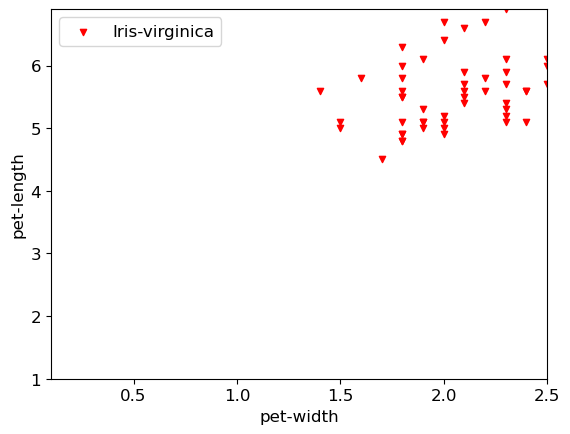

In [25]:
colors = ["blue", "green", "red"]
markers = ["o", "^", "v"]
min_x = iris_df["pet-width"].min()
max_x = iris_df["pet-width"].max()
min_y = iris_df["pet-length"].min()
max_y = iris_df["pet-length"].max()
for i in range(len(varietes)):
    variety = varietes[i]
    
    # make a df just of just the data for this variety
    variety_df = iris_df[iris_df["class"] == variety] 
    
    #make a scatter plot for this variety
    variety_df.plot.scatter(x = "pet-width", y = "pet-length", label=variety, color=colors[i], marker=markers[i], xlim=(min_x, max_x), ylim=(min_y, max_y))

In [26]:
# Have to be VERY careful to not crop out data.
# We'll talk about this next lecture.

In [27]:
# Better yet, we could combine these.

### We can make Subplots in plots, called an AxesSubplot, keyword ax
1. if AxesSuplot ax passed, then plot in that subplot
2. if ax is None, create a new AxesSubplot
3. return AxesSubplot that was used

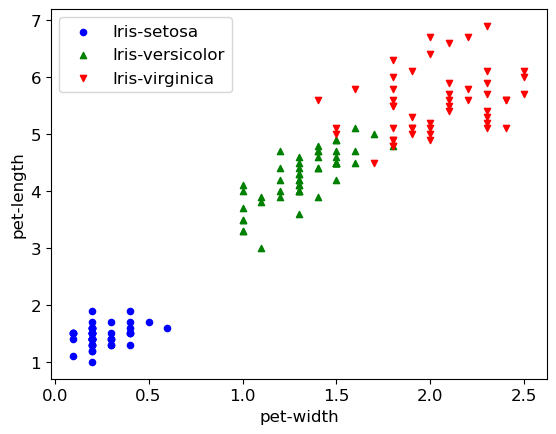

In [28]:
# complete this code to make 3 plots in one

plot_area = None   # don't change this...look at this variable in line 12
colors = ["blue", "green", "red"]
markers = ["o", "^", "v"]
for i in range(len(varietes)):
    variety = varietes[i]
    
    # make a df just of just the data for this variety
    variety_df = iris_df[iris_df["class"] == variety] 
    
    #make a scatter plot for this variety
    plot_area = variety_df.plot.scatter(x = "pet-width", y = "pet-length", label=variety, color=colors[i], marker=markers[i], ax=plot_area)

### Time-Permitting
Plot this data in an interesting/meaningful way & identify any correlations.

In [29]:
students = pd.DataFrame({
    "name": [
        "Cole",
        "Cynthia",
        "Alice",
        "Seth"
    ],
    "grade": [
        "C",
        "AB",
        "B",
        "BC"
    ],
    "gpa": [
        2.0,
        3.5,
        3.0,
        2.5
    ],
    "attendance": [
        4,
        11,
        10,
        6
    ],
    "height": [
        68,
        66,
        60,
        72
    ]
})
students

,name,grade,gpa,attendance,height
0,Cole,C,2.0,4,68
1,Cynthia,AB,3.5,11,66
2,Alice,B,3.0,10,60
3,Seth,BC,2.5,6,72


In [30]:
# Min, Max, and Overall Difference in Student Height
min_height = students["height"].min()
max_height = students["height"].max()
diff_height = max_height - min_height

# Normalize students heights on a scale of [0, 1] (black to white)
height_colors = (students["height"] - min_height) / diff_height

# Normalize students heights on a scale of [0, 0.5] (black to gray)
height_colors = height_colors / 2 

# Color must be a string (e.g. c='0.34')
height_colors = height_colors.astype("string")

height_colors

0    0.3333333333333333
1                  0.25
2                   0.0
3                   0.5
Name: height, dtype: string

<Axes: xlabel='attendance', ylabel='gpa'>

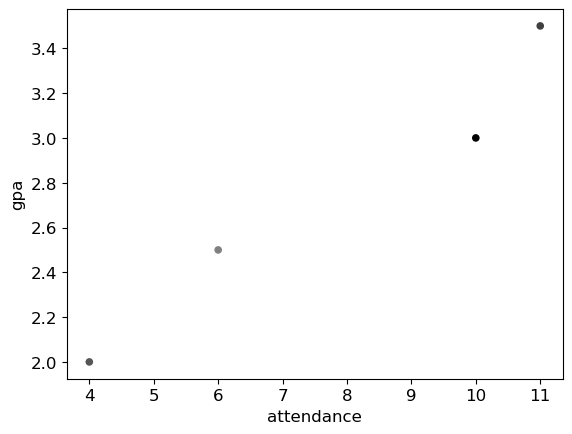

In [31]:
students.plot.scatter(x="attendance", y="gpa", c=height_colors)

In [32]:
students.corr()

C:\Users\ctnelson1997\AppData\Local\Temp\ipykernel_20336\882796491.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  students.corr()


,gpa,attendance,height
gpa,1.000000,0.976831,-0.464758
attendance,0.976831,1.000000,-0.635586
height,-0.464758,-0.635586,1.000000


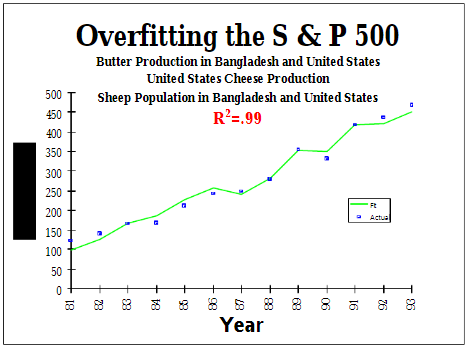

https://www.researchgate.net/publication/247907373_Stupid_Data_Miner_Tricks_Overfitting_the_SP_500